# Анализ, обучение и выбор моделей

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ShuffleSplit

import pandas as pd
import numpy as np
import random
import re

import matplotlib.pyplot as plt
import warnings

import pickle
import collections

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable

import scipy.sparse

In [73]:
MAX_DF = 0.8
MIN_COUNT = 5
TOKEN_RE = re.compile(r'[\w\d]+')

In [74]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

In [75]:
train = pd.read_csv('train_spam.csv')
test= pd.read_csv('test_spam.csv')

In [76]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Инвертирование меток классов
inverted_labels = ["ham" if label == "spam" else "spam" for label in train['text_type']]

train['text_type'] = label_encoder.fit_transform(inverted_labels)
train['text_type']

0        1
1        1
2        0
3        0
4        1
        ..
16273    0
16274    0
16275    1
16276    1
16277    1
Name: text_type, Length: 16278, dtype: int64

In [77]:
print('Количество обучающих текстов', len(train))
print('Количество тестовых текстов', len(test))
print()
print(train['text'][0].strip())

print()
print('Метка', train['text_type'][0])

Количество обучающих текстов 16278
Количество тестовых текстов 4070

make sure alex knows his birthday is over in fifteen minutes as far as youre concerned

Метка 1


In [5]:
nltk.download('punkt', quiet = True)
nltk.download('wordnet', quiet = True)

True

In [94]:
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [lemmatizer.lemmatize(token) for token in all_tokens if len(token) >= min_token_size]

## TF-IDF с логистической регрессией с использованием sklearn

In [95]:
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_and_lemmatize,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT,
                                                      stop_words = 'english')),
                             ('cls', LogisticRegression(n_jobs = -1))))

##### hold_out в sklearn реализации

##### Применение grid-search для поиска наилучших гиперпараметров

In [96]:
warnings.filterwarnings("ignore")

param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],
    'cls__C': [0.1, 1, 10, 15, 20]
}
X_train, X_local_test, y_train, y_local_test = train_test_split(train['text'], train['text_type'], test_size = 0.1, random_state = 42)
shuffle_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

grid_search = GridSearchCV(sklearn_pipeline, param_grid, cv = shuffle_split, scoring='roc_auc', verbose=0)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение ROC AUC:", grid_search.best_score_)

best_model_hold_out = grid_search.best_estimator_

Лучшие параметры: {'cls__C': 20, 'vect__max_df': 0.5, 'vect__min_df': 1}
Лучшее значение ROC AUC: 0.9748749391727493


In [97]:
#сохранение модели логистической регрессии с hold out разбиением
# with open('1_logreg_holdout.pkl', 'wb') as f:
#     pickle.dump(best_model_hold_out, f)

In [98]:
sklearn_train_pred = best_model_hold_out.predict_proba(X_train)
print('roc_auc на train', roc_auc_score(y_train, sklearn_train_pred[:, 1]))

sklearn_test_pred = best_model_hold_out.predict_proba(X_local_test)
print('roc_auc на val', roc_auc_score(y_local_test, sklearn_test_pred[:, 1]))

roc_auc на train 0.999464283929718
roc_auc на val 0.9770045810966528


##### График ROC-кривой на тренировочной выборке

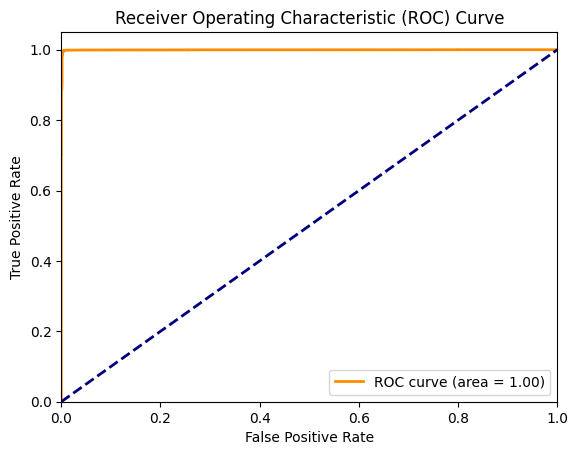

In [99]:
y_train_scores = sklearn_train_pred[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### График ROC-кривой на валидационной выборке

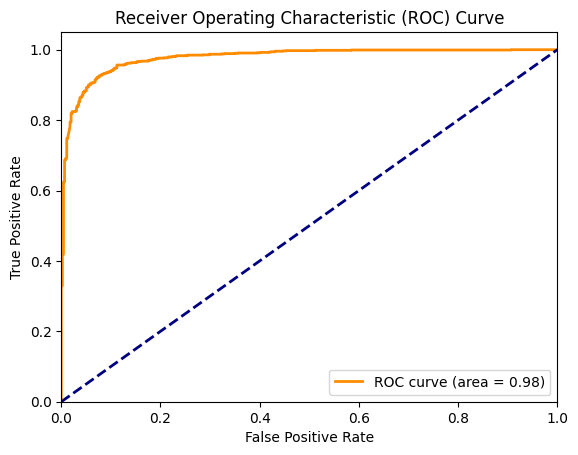

In [100]:
y_val_scores = sklearn_test_pred[:, 1]
fpr_val, tpr_val, thresholds_val = roc_curve(y_local_test, y_val_scores)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Использование KFold в sklearn реализации

In [102]:
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],
    'cls__C': [0.1, 1, 10, 15, 20]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_fold = GridSearchCV(estimator=sklearn_pipeline, param_grid=param_grid, cv=skf, scoring='roc_auc')

grid_search_fold.fit(X_train, y_train)

# Вывод лучших параметров и результатов
print("Лучшие параметры:", grid_search_fold.best_params_)
print("Лучший ROC AUC:", grid_search_fold.best_score_)

Лучшие параметры: {'cls__C': 20, 'vect__max_df': 0.5, 'vect__min_df': 1}
Лучший ROC AUC: 0.9774131685008995


In [103]:
best_model_fold = grid_search_fold.best_estimator_

#сохранение модели логистической регрессии с StratifiedKFold разбиением
# with open('2_logreg_strkfold.pkl', 'wb') as f:
#     pickle.dump(best_model_fold, f)

##### График roc_auc лучшей модели на train

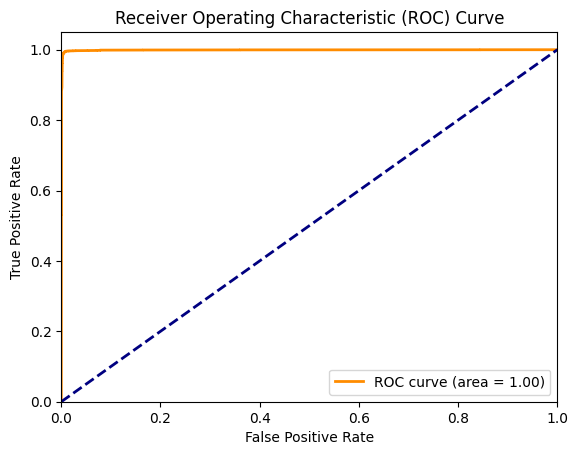

In [58]:
y_train_pred_proba_fold = best_model_fold.predict_proba(X_train)[:, 1]

fpr_train_fold, tpr_train_fold, thresholds_val_fold = roc_curve(y_train, y_train_pred_proba_fold)

roc_auc_train_fold = auc(fpr_train_fold, tpr_train_fold)

plt.figure()
plt.plot(fpr_train_fold, tpr_train_fold, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train_fold)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### График roc_auc лучшей модели на val

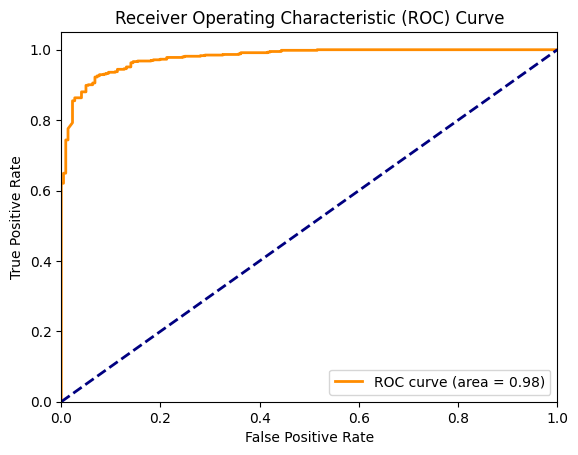

In [60]:
y_val_pred_proba_fold = best_model_fold.predict_proba(X_local_test)[:, 1]

fpr_val_fold, tpr_val_fold, thresholds_val_fold = roc_curve(y_local_test, y_val_pred_proba_fold)

roc_auc_val_fold = auc(fpr_val_fold, tpr_val_fold)

plt.figure()
plt.plot(fpr_val_fold, tpr_val_fold, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val_fold)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## TF-IDF с использованием Torch - Простая глубокая нейронная сеть

In [877]:
remove_non_alphabets_and_numbers =lambda x: re.sub(r'[^\w\d]+',' ',x)

In [878]:
tokenize = lambda x: word_tokenize(x)

In [879]:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

In [880]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [881]:
X_train_2 = train['text']
y_train_2 = train['text_type']

In [882]:
print('Processing : [=', end='')
X_train_2 = X_train_2.apply(remove_non_alphabets_and_numbers)
print('=', end='')
X_train_2 = X_train_2.apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
X_train_2 = X_train_2.apply(stem)
print('=', end='')
X_train_2 = X_train_2.apply(leammtizer)
print('=', end='')
X_train_2 = X_train_2.apply(lambda x: ' '.join(x))
print('] : Completed', end='')
X_train_2.head()

Processing : [=====] : Completed

0    make sure alex know hi birthday is over in fif...
1    a resum for john lavorato thank vinc i will ge...
2    plzz visit my websit moviesgodml to get all mo...
3    urgent your mobil number ha been award with a ...
4    overview of hr associ analyst project per davi...
Name: text, dtype: object

In [886]:
max_words = 18919
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(X_train_2).toarray()

In [887]:
sparse_matrix.shape

(16278, 18919)

In [888]:
x_train_3, x_local_test_3, y_train_3, y_local_test_3 = train_test_split(sparse_matrix, np.array(y_train_2), test_size = 0.1, random_state = 42)

In [889]:
class LogisticRegression_2(nn.Module):
    def __init__(self):
        super(LogisticRegression_2, self).__init__()
        self.linear1 = nn.Linear(18919, 200)
        self.linear2 = nn.Linear(200, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [890]:
model = LogisticRegression_2()

In [891]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

In [892]:
x_train_3 = Variable(torch.from_numpy(x_train_3)).float()
y_train_3 = Variable(torch.from_numpy(y_train_3)).long()

Epoch: 1, Loss: 0.7459142804145813, Accuracy: 29.720136642456055%, ROC AUC: 0.46398465771456127
Epoch: 2, Loss: 0.6227877736091614, Accuracy: 57.25597381591797%, ROC AUC: 0.7157732518464028
Epoch: 3, Loss: 0.5056370496749878, Accuracy: 74.62116241455078%, ROC AUC: 0.8033679097786814
Epoch: 4, Loss: 0.44167444109916687, Accuracy: 84.70989990234375%, ROC AUC: 0.868916955231264
Epoch: 5, Loss: 0.3753764033317566, Accuracy: 89.8156967163086%, ROC AUC: 0.9287762634828551
Epoch: 6, Loss: 0.31155887246131897, Accuracy: 92.87371826171875%, ROC AUC: 0.962512657046419
Epoch: 7, Loss: 0.2519661784172058, Accuracy: 94.70989990234375%, ROC AUC: 0.9797639391690839
Epoch: 8, Loss: 0.19620823860168457, Accuracy: 95.59044647216797%, ROC AUC: 0.9882055020720616
Epoch: 9, Loss: 0.1494964212179184, Accuracy: 96.17747497558594%, ROC AUC: 0.9923705269364435
Epoch: 10, Loss: 0.1166907548904419, Accuracy: 96.47099304199219%, ROC AUC: 0.9941820862238869
Epoch: 11, Loss: 0.09573608636856079, Accuracy: 96.641639

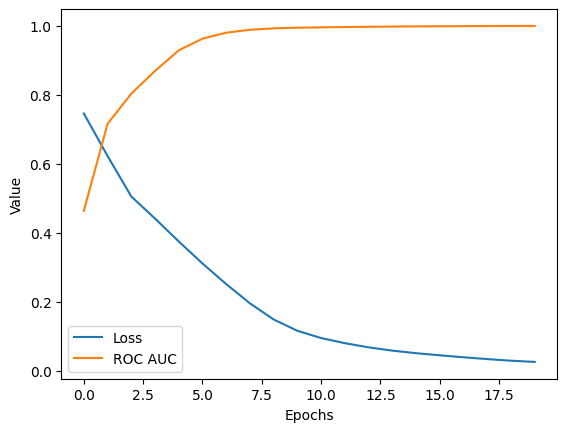

In [893]:
epochs = 20
model.train()
loss_values = []
roc_auc_values = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred_3 = model(x_train_3)
    loss = criterion(y_pred_3, y_train_3)
    loss_values.append(loss.item())
    
    probs_train = torch.softmax(y_pred_3, dim=1)[:, 1].detach().numpy()
    roc_auc = roc_auc_score(y_train_3.numpy(), probs_train)
    roc_auc_values.append(roc_auc)
    
    pred = torch.max(y_pred_3, 1)[1].eq(y_train_3).sum()
    acc = pred * 100.0 / len(x_train_3)
    
    print('Epoch: {}, Loss: {}, Accuracy: {}%, ROC AUC: {}'.format(epoch+1, loss.item(), acc.numpy(), roc_auc))
    
    loss.backward()
    optimizer.step()

plt.plot(loss_values, label='Loss')
plt.plot(roc_auc_values, label='ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

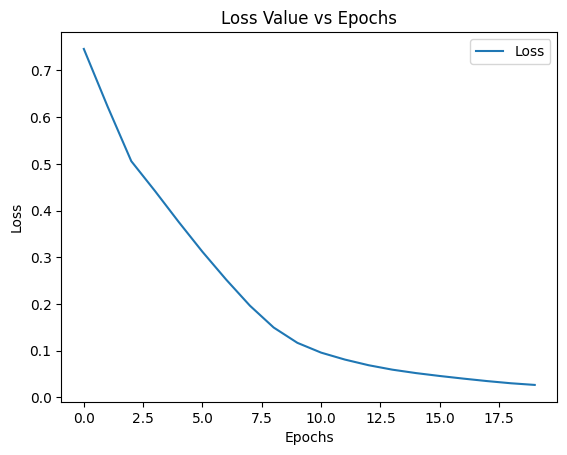

In [894]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [895]:
x_local_test_3 = Variable(torch.from_numpy(x_local_test_3)).float()
y_local_test_3 = Variable(torch.from_numpy(y_local_test_3)).long()

ROC-AUC для обучающего набора: 0.9994843603163539
ROC-AUC для тестового набора: 0.97629165378526


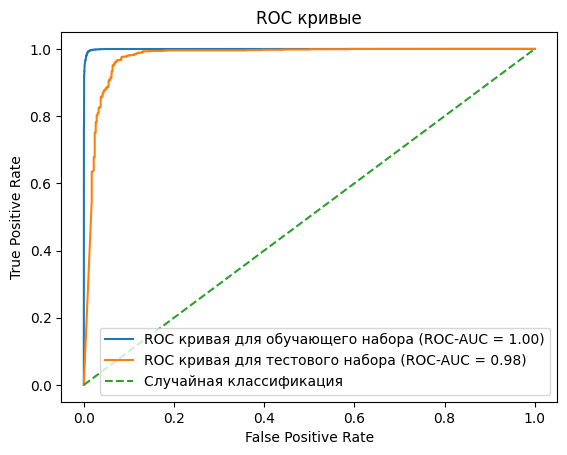

In [896]:
x_train_3 = x_train_3.view(x_train_3.size(0), -1)
model.eval()
with torch.no_grad():
    y_pred_train = model(x_train_3)
    probs_train = torch.softmax(y_pred_train, dim=1)[:, 1].numpy()

with torch.no_grad():
    y_pred_test = model(x_local_test_3)
    probs_test = torch.softmax(y_pred_test, dim=1)[:, 1].numpy()

auc_train = roc_auc_score(y_train_3.numpy(), probs_train)
auc_test = roc_auc_score(y_local_test_3.numpy(), probs_test)

print("ROC-AUC для обучающего набора:", auc_train)
print("ROC-AUC для тестового набора:", auc_test)

fpr_train, tpr_train, _ = roc_curve(y_train_3.numpy(), probs_train)
fpr_test, tpr_test, _ = roc_curve(y_local_test_3.numpy(), probs_test)

plt.plot(fpr_train, tpr_train, label='ROC кривая для обучающего набора (ROC-AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='ROC кривая для тестового набора (ROC-AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная классификация')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые')
plt.legend()
plt.show()

#### Приоритет отдается глубокой нейронной сети из-за более высокого показателя ROC-AUC

In [897]:
torch.save(model.state_dict(), '3_deepnet.pth')

## Получим результат работы модели на тестовой выборке

In [911]:
X_test_final = test['text']

In [912]:
print('Processing : [=', end='')
X_test_final = X_test_final.apply(remove_non_alphabets_and_numbers)
print('=', end='')
X_test_final = X_test_final.apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
X_test_final = X_test_final.apply(stem)
print('=', end='')
X_test_final = X_test_final.apply(leammtizer)
print('=', end='')
X_test_final = X_test_final.apply(lambda x: ' '.join(x))
print('] : Completed', end='')
X_test_final.head()

Processing : [=====] : Completed

0    j jim whitehead ejw cse ucsc edu write j you o...
1    origin messag from bitbitch magnesium net peop...
2    java for manag vinc durasoft who just taught t...
3                    there is a youtub name saiman say
4    underpr issu with high return on equiti the oi...
Name: text, dtype: object

In [913]:
X_test_sparse_matrix = cv.fit_transform(X_test_final).toarray()
X_test_final = Variable(torch.from_numpy(X_test_sparse_matrix)).float()

In [914]:
with torch.no_grad():
    y_pred_test_final = model(X_test_final)
    predicted_labels_final = torch.argmax(y_pred_test_final, dim=1).numpy()

In [921]:
predicted_labels_final_str = np.where(predicted_labels_final == 0, 'spam', 'ham')

In [930]:
test['score'] = predicted_labels_final_str
test = test.reindex(columns = ['score', 'text'])

In [931]:
test

,score,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you ...
1,ham,original message from bitbitch magnesium net p...
2,ham,java for managers vince durasoft who just taug...
3,ham,there is a youtuber name saiman says
4,ham,underpriced issue with high return on equity t...
...,...,...
4065,ham,husband to wifetum meri zindagi hoorwifeor kya...
4066,ham,baylor enron case study cindy yes i shall co a...
4067,ham,boring as compared to tp
4068,ham,hellogorgeous hows u my fone was on charge lst...


In [932]:
test.to_csv('scored_test.csv')